# Complicating Social Contagion

## Section 1: Background
### 1.1 Learning Objectives
- Explore different aspects of social influence that affect social contagion processes.

### 1.2 Data
- This lab uses data collected from Twitter. Before the lab, we already collected the data and did a lot to clean it up. In the lab, will focus on using the data to understand social contagion.
- We will look at the spread of the hashtag #metoo on Twitter. [The Me Too Campaign began in 2007](https://www.nytimes.com/2017/10/20/us/me-too-movement-tarana-burke.html). The hashtag became extremely popular on Twitter starting in October, 2017. It was tweeted more than 7 million times in the first 4 months after that.
- Me Too is a social movement that calls attention to sexual assault and harassment. We will not be looking at the text of any of the tweets in this lab. For our purposes here, we just want to look at how being exposed to other people talking about #metoo on Twitter influences someone to also talk about #metoo on Twitter.
- Fun fact: the data Jeff collected for this lab was used in a published research paper!
    - Gallagher, R.J., Stowell, E., Parker, A.G. and Foucault Welles, B., 2019. [Reclaiming stigmatized narratives: The networked disclosure landscape of #MeToo.](https://dl.acm.org/doi/abs/10.1145/3359198) Proceedings of the ACM on Human-Computer Interaction, 3(CSCW), pp.1-30.
    
@Author: [Jeff Lockhart](http://www-personal.umich.edu/~jwlock/)

## Section 2: Setup
#### Import Python Modules

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.colors import LogNorm

#plt.style.use('fivethirtyeight')
%matplotlib inline

In [2]:
#plt.style.use('fivethirtyeight')
plt.style.use('ggplot')

## Section 3: Spread of MeToo

#### Load data & helper function

In [3]:
def downcast(df):
    tmp = df.select_dtypes(int)
    for c in tmp.columns.values:
        df[c] = pd.to_numeric(df[c], downcast='unsigned')
    
    tmp = df.select_dtypes(float)
    for c in tmp.columns.values:
        df[c] = pd.to_numeric(df[c], downcast='float')

pcts = pd.read_csv('data/daily_pcts.tsv', sep='\t', index_col=0)
pcts.index = pd.to_datetime(pcts.index)
downcast(pcts)

counts = pd.read_csv('data/daily_counts.tsv', sep='\t', index_col=0)
counts.index = pd.to_datetime(counts.index)
downcast(counts)

#### Every day, a few people used the hashtag #metoo
- Take a look at the chart below. It shows how many tweets were made every day using the hashtag #metoo
- Notice that people on twitter did use the hashtag #metoo before October 15, 2017.

<ipython-input-4-5bb5f7d3df86>:1: FutureWarning: The pandas.datetime class is deprecated and will be removed from pandas in a future version. Import from datetime module instead.
  event = pd.datetime(2017,10,15)


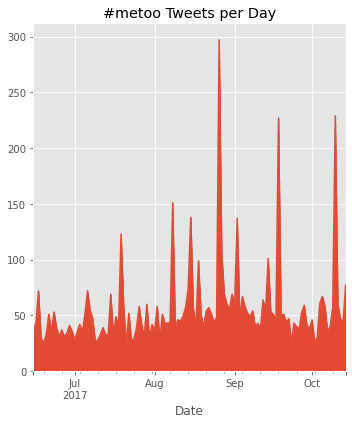

In [4]:
event = pd.datetime(2017,10,15)

counts[counts.index < event].tweets.plot.area(figsize=(5,6), title='#metoo Tweets per Day')
plt.tight_layout()

#### Then something happened
- On October 15, 2017, producer and actress Alyssa Milano used the hashtag, and there were 600,000 tweets about it within a single day.
- Since then, the number of #metoo tweets per day has been mugh higher.
- It is possible that some of these people are coming up with the hashtag on their own. However, we saw above that before Milano tweeted, not many tweets used the hashtag. The extreme and fast growth of the hashtag suggests a process of social influence or contagion: people are getting the idea from seeing other people use it.

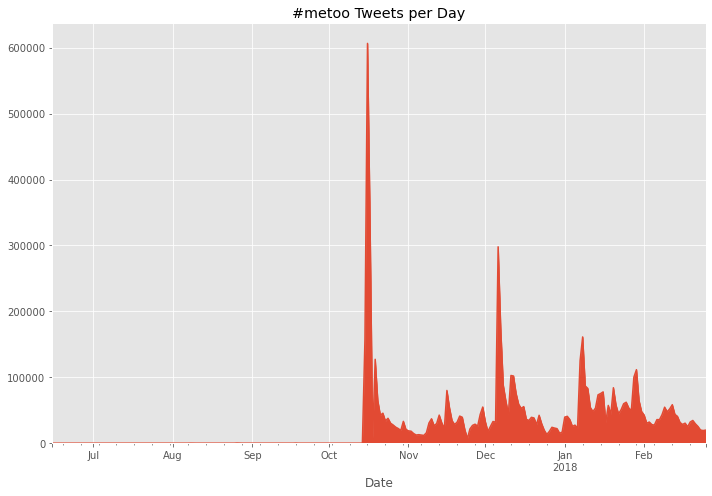

In [5]:
counts.tweets.plot.area(figsize=(10,7), title='#metoo Tweets per Day')
plt.tight_layout()

#### Short answer 1:
- After the initial October 15 rush of tweets, there are several other days where the number of tweets jumps up. In a few sentences, write what you think might be happening on those days.

**🤔Your answers here**

#### Cumulative plots
- In the chart below, we show how the total number of tweets about #metoo grows over time. This is called a "cumulative" plot, because the tweets "accumulate" over time. That is, the value for each day is the total number of tweets about #metoo that have happened up to that day. As time goes on, the number of tweets that have ever been made can only go up, so each day is as high or higher than the day before it (we ignore deleted tweets).
- We also show how the number of people using the hashtag grows over time.
- Notice that participation does not grow at a constant rate. Instead, it grows in bursts, just like the daily tweeting happens in bursts.

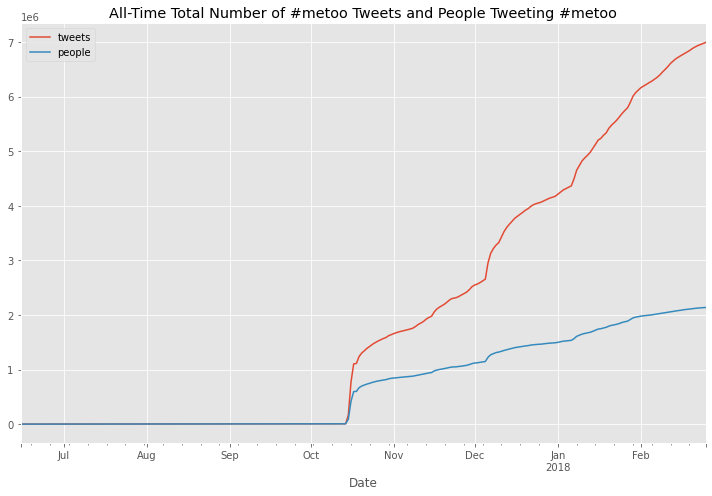

In [6]:
counts.cumsum().plot(figsize=(10,7), title='All-Time Total Number of #metoo Tweets and People Tweeting #metoo')
plt.tight_layout()

#### Most #metoo tweets are social
- There are different kinds of tweets on Twitter. These are the two most common ones:
    - **New tweets** are when someone writes a tweet and posts it.
    - **Retweets** are when someone shares another person's tweet.
- Retweets involve a user interacting with other users: sharing what they wrote. They're a clear example of contagion because one user literally got the tweet from another user.
- In the two charts below, we see that the majority of tweets about #metoo are retweets. 

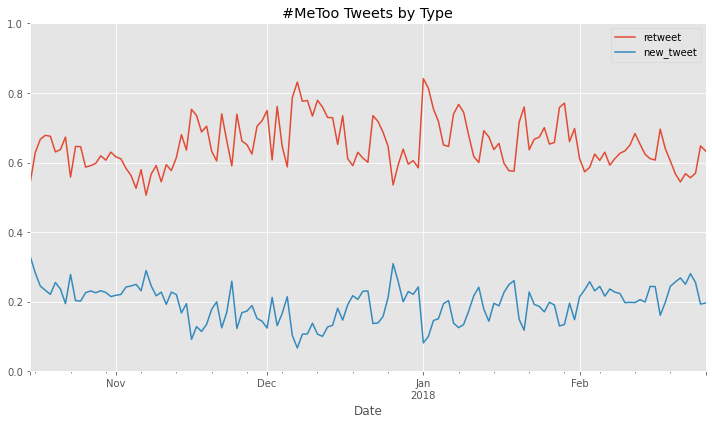

In [7]:
pcts.plot.line(y=['retweet', 'new_tweet'], ylim = [0,1],
              figsize=(10,6), title='#MeToo Tweets by Type')
plt.tight_layout()

## Section 4: How much exposure to #metoo do people have before joining?
- **Imortant note**: in this lab a person's "exposure" to #metoo means the number of times they have seen tweets about it. We're using "exposure" in the disease sense, as in "was I exposed to COVID-19?" We do not mean "exposure" the way "paid in exposure" does: exposure is not how many other people have been "exposed" to my tweets. It is how many tweets I've seen.
- The cell below loads and prepares data for this section. You don't need to understand it right now. Run the cell and scroll down.

In [8]:
#load data
tfm = pd.read_csv('data/tweets_friends_mentions_all.tsv', sep='\t')
#focus on people who have seen < 2,000 tweets (most people)
tfm = tfm[(tfm.tweets_seen <=2000)]
downcast(tfm)

tweets_seen = pd.read_csv('data/tweets_seen.tsv', sep='\t')
friends_seen = pd.read_csv('data/friends_seen.tsv', sep='\t')

#helper function 
def calc_probs(df):
    df['pct_tweeted'] = df.n_tweeted / df.n_tweeted.max()
    
    if 'n_viewers' in df.columns:
        df['prob_at_exact_exposure'] = df.n_tweets / (df.n_viewers + df.n_tweets) 
    else:
        df['prob_at_exact_exposure'] = np.NaN
    
    df.sort_values(by='views', ascending=False, inplace=True)
    df['n_viewers_metoo'] = df.n_tweets.cumsum()
    df.sort_values(by='views', ascending=True, inplace=True)
    df['joiners_prob_at_exact_exposure'] = df.n_tweets / (df.n_viewers_metoo)     
    downcast(df)
    return df
    
tweets_seen = calc_probs(tweets_seen)
friends_seen = calc_probs(friends_seen)

- We know that people are getting the idea to use #metoo from each other. In this section, we'll look at how much exposure to #metoo they had from other users. That is, we will see how many times people were exposed to #metoo before they participated by tweeting about it themselves.
- In the plot below, we see one dot for every person who tweeted #metoo. 
    - The dot indicates how many tweets (x axis) and friends (y axis) they saw tweeting about #metoo before they made their first #metoo tweet. So someone who saw 200 tweets from 50 friends would be shown as a dot at x=200, y=50
    
**Note:** The charts in the rest of the lab have more code than usual. This is just so that we can set up the labels and make the charts pretty. Don't worry about the details of that formatting code (lines starting with `ax` or `plt`).

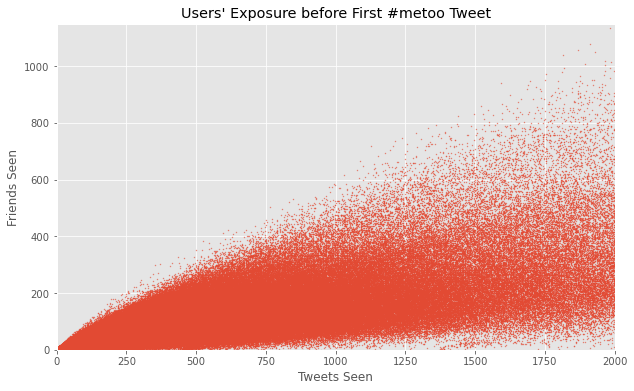

In [9]:
fig, ax = plt.subplots(figsize=(10,6))
plt.scatter(x=tfm.tweets_seen, y=tfm.friends_seen, s=1, alpha=.5)
ax.set_ylabel('Friends Seen')
ax.set_xlabel('Tweets Seen')
ax.set_title("Users' Exposure before First #metoo Tweet")
ax.set_xlim(0,2000)
ax.set_ylim(0,1150)
plt.show()

#### Seeing this more clearly
- It is hard to see individual people in the chart above, because there are 2 million people all crammed into a small amount of space on our screens.
- The chart below color codes each area of the chart by how many people are there. This lets us see how densely packed the points are. Or, in other words, it lets us see what values are most and least common.
    - The dark blue areas have very few people ($10^0 = 1$). 
    - The green areas have more people (e.g. $10^3 = 1,000$)
    - The bright yellow areas have a lot of people ($10^5 = 100,000$)

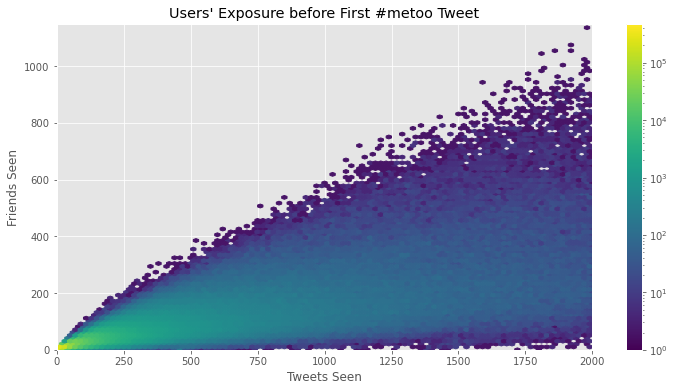

In [10]:
fig, ax = plt.subplots(figsize=(12,6))
#plt.hist2d(x=tfm.tweets_seen, y=tfm.friends_seen, bins=60, norm=LogNorm())
#hexbin is another way of getting the same plot as 2dhist
plt.hexbin(x=tfm.tweets_seen, y=tfm.friends_seen, bins=800000, norm=LogNorm())
ax.set_ylabel('Friends Seen')
ax.set_xlabel('Tweets Seen')
ax.set_title("Users' Exposure before First #metoo Tweet")
ax.set_xlim(0,2000)
ax.set_ylim(0,1150)
ax.grid(True)
plt.colorbar()
plt.show()

#### Short Answer 2:
- The plot above shows that joining is most common at low levels of exposure, and the level of exposure before joining #metoo for the first time varies across people.
- If we assume the deterministic threshold model applies here, how do you explain the patterns you observe in the plot above? 
- If we assume the stochastic threshold model applies here, how do you explain the patterns you observe in the plot above? 

**🤔Your answers here**

#### How much exposure do most people have when they join?
- In the charts above, it is hard to see in them how much exposure is required for a majority of people.
- In the next chart, we look at the same data with a cumulative plot. We show the cumulative number of people who have joined by the time their exposure reaches x.
    - So, for example, the chart below says that of the people who eventually tweeted #metoo, 80% of them made their first tweet after seeing fewer than 100 of the people they follow tweet #metoo.
- **Try it:** run the code below several times, picking different numbers for the `maximum_exposure` in order to zoom in and out.

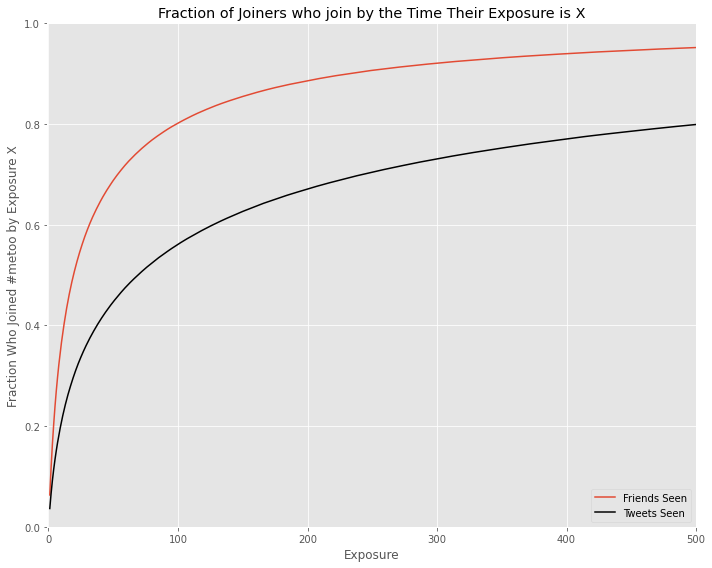

In [31]:
maximum_exposure = 500

fig, ax = plt.subplots(figsize=(10,8))
plt.plot(friends_seen.views, friends_seen.pct_tweeted, label='Friends Seen')
plt.plot(tweets_seen.views, tweets_seen.pct_tweeted, label='Tweets Seen', color='black')
ax.set_ylabel('Fraction Who Joined #metoo by Exposure X')
ax.set_xlabel('Exposure')
ax.set_xlim(-1, maximum_exposure)
ax.set_ylim(0, 1)
ax.set_title('Fraction of Joiners who join by the Time Their Exposure is X')
plt.legend(loc='lower right')
plt.tight_layout()
plt.show()

#### Short Answer 3:
- The majority of people (51%) have tweeted by the time they get to what level of exposure? Write how many tweets they have seen, and how many friends they have seen tweeting in a full sentence.

**🤔Your answers here**

## Section 5: Does more exposure make people *less* likely to join?
- We saw above that most people join at low levels of exposure. 
- Does this mean that more exposure makes people less likely to join? We will find out in this section

#### Short answer 4:
- Before we do, make a prediction:
- Two senarios might be possible after people get more exposure
    - 1. They are *more* willing to tweet about #metoo by seeing more people doing it.
    - 2. They are *less* willing to tweet about #metoo by seeing more people doing it.
- Explain why **each of the two** senarios might occur in a few sentences. Which one do you think is more plausible?

**🤔Your answers here**

#### Let's see if you're right!
#### Probability of tweeting #metoo based on amount of exposure
- The plot below shows how many times someone has been exposed to the hashtag #metoo on the X axis.
    - The number of tweets they have seen is the number of times people they follow have tweeted about #metoo
    - The number of people seen is the number of people they follow who have tweeted about #metoo.
- On the Y axis, they show the probability that someone will make their first #metoo tweet, after having seen X number of tweets or people tweeting about #metoo (**and before seeing X+1 number of tweets or people tweeting about #metoo**).
    - Probability ranges from 0 (it definitely will not happen) to 1 (it definitely will happen). Getting "heads" on a coin toss has a probability of 0.5 (50%). Rolling a one on a six-sided die has a probability of $1/6 \approx 0.1667$ (16.67%). 
    - So, for example, if people who have seen exactly 20 of the people they follow tweet about #metoo have a 0.02 probability of making their first #metoo tweet, that's a 2% chance of "catching" the "contagion."
- **Try it:** change the `max_exposure` variable to zoom in and out on the x axis.  

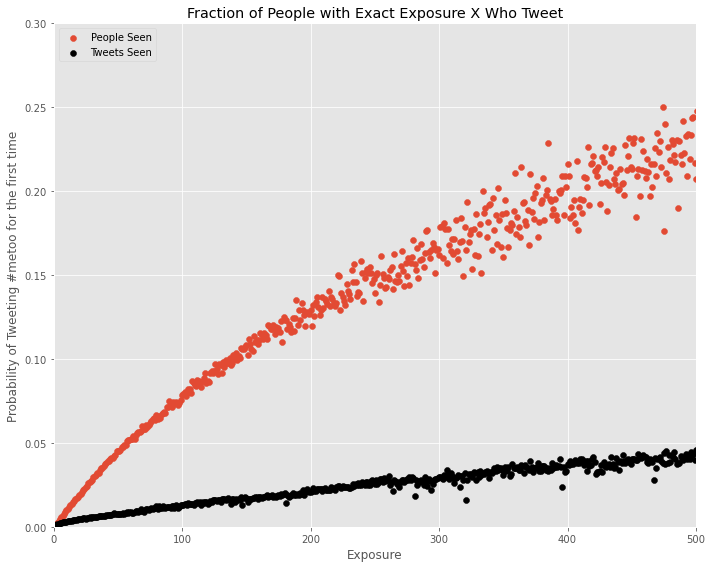

In [12]:
max_exposure = 500

fig, ax = plt.subplots(figsize=(10,8))
plt.scatter(x=friends_seen.views, y=friends_seen.prob_at_exact_exposure, label='People Seen')
plt.scatter(x=tweets_seen.views, y=tweets_seen.prob_at_exact_exposure, label='Tweets Seen', color='black')
ax.set_ylabel('Probability of Tweeting #metoo for the first time')
ax.set_xlabel('Exposure')
ax.set_xlim(0, max_exposure)
ax.set_ylim(0, 0.3)
ax.set_title('Fraction of People with Exact Exposure X Who Tweet')
plt.legend(loc='upper left')
plt.tight_layout()
plt.show()

#### Short Answer 5:
- Why is the trend of red dots higher than the trend of black dots? Was your prediction above correct? 

**🤔Your answers here**

### Why does this happen?
- The chart above tells us that high exposure people are more likely to tweet than low exposure people. But the charts before that told us that most people who tweet about #metoo do so at lower levels of exposure. 
- This happens because there are different numbers of people at each level of exposure. 41 million people saw one tweet about #metoo, but only 12 million people saw 5 tweets about it, and only 164 thousand people saw 100 tweets about it. You can see this in the chart below.
- Thus, even though only 1 out of 1,000 people who see #metoo one time tweet about it, so many people see it one time that the number of people tweeting after one exposure is 41,865. People who see #metoo 100 times are 12 times more likely to tweet about it than those who only saw it once (12 out of 1,000). But because so few people are exposed 100 times, the total number tweeting after 100 exposures is just 1,977 (that is 20 times fewer people)!

*The number of people tweet after seeing X exposure  
 = probability that people tweet after seeing X exposure * number of people saw X exposure*

$(0.001*41865986) > (0.012*164788)$
    
$41865 > 1977$

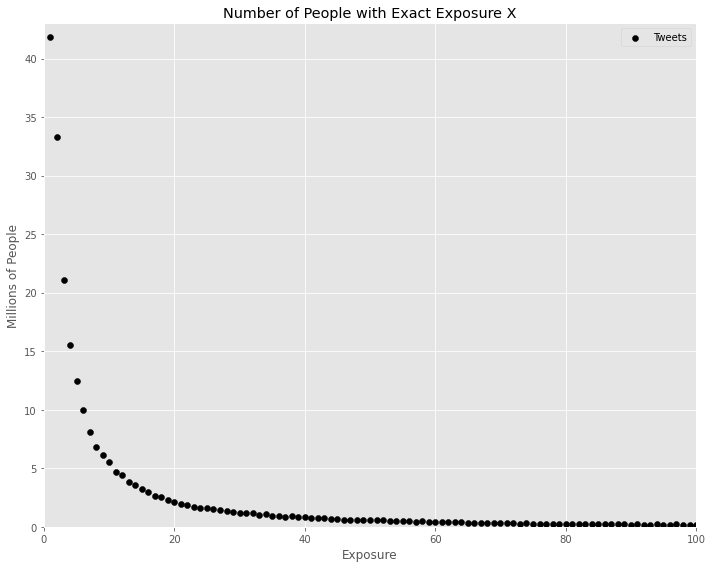

In [13]:
max_exposure = 100

fig, ax = plt.subplots(figsize=(10,8))
#plt.scatter(x=friends_seen.views, y=friends_seen.n_viewers/1000000, label='People')
plt.scatter(x=tweets_seen.views, y=tweets_seen.n_viewers/1000000, label='Tweets', color='black')
ax.set_ylabel('Millions of People')
ax.set_xlabel('Exposure')
ax.set_xlim(0, max_exposure)
ax.set_ylim(0, 43)
ax.set_title('Number of People with Exact Exposure X')
plt.legend(loc='upper right')
plt.tight_layout()
plt.show()

#### Short Answers 6:
- As people's exposure to #metoo increases, so does their probability of tweeting #metoo. In other words, sometimes people need multiple exposures to "catch" #metoo. 
    - We have assumed that people see 100% of tweets in their feed. Yet in reality, we don’t know if people really read all of the tweets in their feed. If people only see a fraction of all the tweets in their feed, say 10%, do you think our conclusion is still valid? Write a few sentences explaining why or why not.
- What about the people who tweet about #metoo before any of their friends do? What exposure they can get? Write your explanation in a few sentences.

**🤔Your answers here**

## Section 6: Are close friends more influential than other friends?
- - Before, we were looking at the users that people follow. Following shows interest and means that you'll see what that person tweets in your feed. On twitter, people you follow are called your friends.
    - But some users follow a lot of people, and they might not care about all of them equally. 
    - A stronger signal that one user is paying attention to another user is a `mention`: when someone tags someone else in a tweet. Users generally mention fewer people than they follow, and they might mention someone they do not follow.
    - For this lab, we will compare what happens when we look at all friends with when we look only at friends that a user mentions by name. 
- Below, we will compare the effects of seeing someone you follow tweet with seeing a friend you have mentioned tweet. 

#### Load and process data
- Run this code and scroll down. Don't worry about how it works for now.

In [14]:
close_friends_seen = pd.read_csv('data/mentions_friends_seen.tsv', sep='\t')
far_friends_seen = pd.read_csv('data/far_friends_seen.tsv', sep='\t')

close_friends_seen = calc_probs(close_friends_seen)
far_friends_seen = calc_probs(far_friends_seen)

#### The influence of close friends
- The plot below shows the cumulative number of people who have tweeted #metoo by the time they were exposed by X number of friends or close friends.

🤔**Try it:** zoom in and out in this chart by changing the value of `max_exposure`.

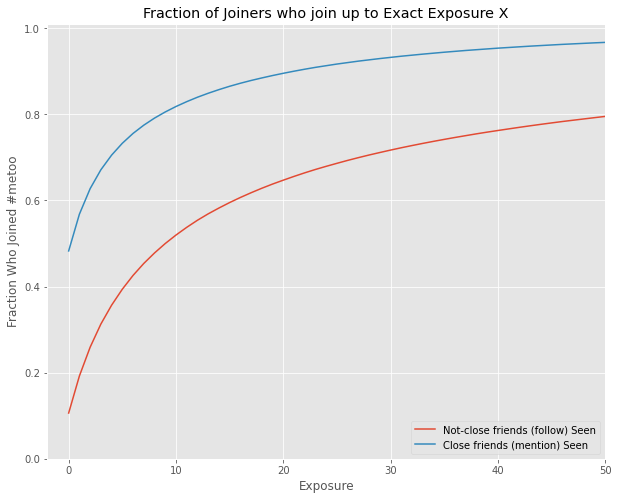

In [33]:
max_exposure = 50

fig, ax = plt.subplots(figsize=(10,8))
plt.plot(far_friends_seen.views, far_friends_seen.pct_tweeted, label='Not-close friends (follow) Seen')
plt.plot(close_friends_seen.views, close_friends_seen.pct_tweeted, label='Close friends (mention) Seen')
ax.set_ylabel('Fraction Who Joined #metoo')
ax.set_xlabel('Exposure')
ax.set_xlim(-2, max_exposure)
ax.set_ylim(0, 1.01)
ax.set_title('Fraction of Joiners who join up to Exact Exposure X')
plt.legend(loc='lower right')
plt.show()

- We see that almost half tweet before any of their close friends do, and around 10% of people tweet before any of their not-close friends do.
- We also see that people who have seen a small number of their close friends tweet are much more likely to tweet than those who have seen the same number of not-close friends tweet.

## Section 7: What's the right number of friends?
- We have seen so far that seeing tweets from more friends makes people more likely to join, but is this just because more friends tweeting means they have seen more tweets?
- To answer this question, we will compare people who have seen the exact same number of tweets, but from different numbers of friends. For example, if I have seen 20 tweets about #metoo, they might all come from one person who tweeted 20 times, from 20 different people who tweeted once, from 10 people who each tweeted twice, etc. 

**Helper functions:** The cell below loads and prepares some data. Run it and scroll down to continue the lab.

In [16]:
vot = pd.read_csv('data/views_over_time_grouped.tsv', sep='\t')
first_new = pd.read_csv('data/tweets_friends_mentions_new.tsv', sep='\t')
first_rt = pd.read_csv('data/tweets_friends_mentions_rt.tsv', sep='\t')

def prep_views(tweets, vot):
    tweets['action'] = 1
    grouped = tweets.groupby(['tweets_seen', 'friends_seen']).sum().reset_index()
    df = vot.merge(grouped, on=['tweets_seen', 'friends_seen'], how='left')
    df['pct'] = (df.action / df.n) * 100
    downcast(df)
    return df

first_tweet = prep_views(tfm, vot)
first_new = prep_views(first_new, vot)
first_rt = prep_views(first_rt, vot)

#### The right number of friends 
- `n_tweets` is the number of tweets that people seen about #metoo, which represents the level of exposure you are interested in looking at.
- The first graph shows you "of the people who saw `n_tweets`, how many saw those tweets all from 1 friend, 2 friends, etc.?"
- The second graph shows you the probability that someone will tweet #metoo, if they have seen `n_tweets` about it from X different friends.

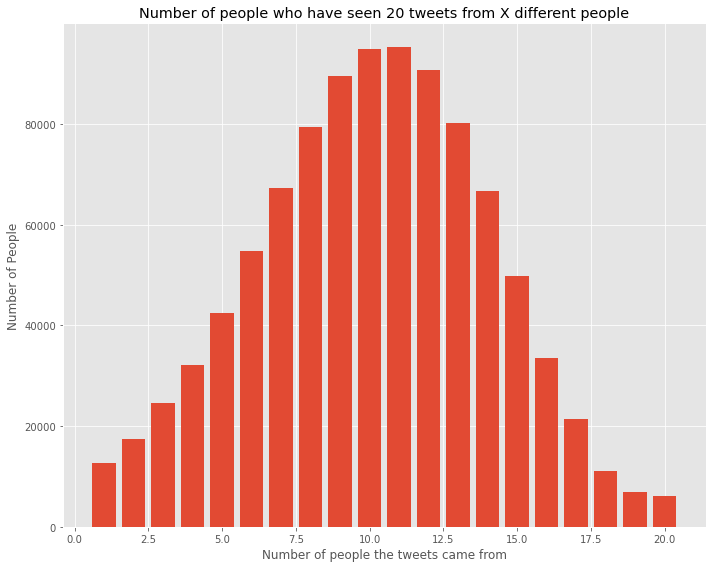

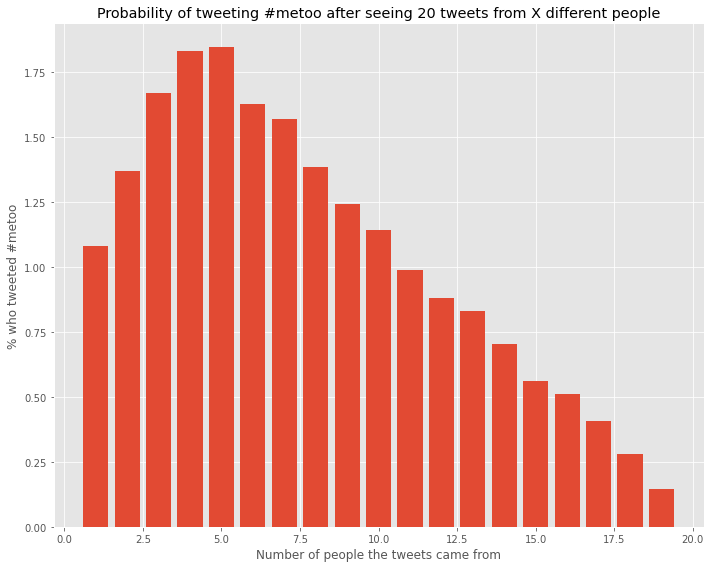

In [40]:
n_tweets = 20

df = first_tweet[first_tweet.tweets_seen == n_tweets]

fig, ax = plt.subplots(figsize=(10,8))
plt.bar(x=df.friends_seen, height=df.n)
ax.set_ylabel('Number of People')
ax.set_xlabel('Number of people the tweets came from')
ax.set_title('Number of people who have seen ' + str(n_tweets) + ' tweets from X different people')
plt.tight_layout()
plt.show()

fig, ax = plt.subplots(figsize=(10,8))
plt.bar(x=df.friends_seen, height=df.pct)
ax.set_ylabel('% who tweeted #metoo')
ax.set_xlabel('Number of people the tweets came from')
ax.set_title('Probability of tweeting #metoo after seeing ' + str(n_tweets) + ' tweets from X different people')
plt.tight_layout()
plt.show()

#### Short answer 7:
- When we set ``n_tweets = 20``,
    - It looks like people are less likely to tweet if all the tweets they saw came from different people (on the right in the graphs) than if they came from a few people (on the left side). 
    - It also looks like people are less likely to tweet if all of the tweets they see come from the same person. 
    - In a few sentences, say what you think might be causing these results. 
- Pick any number from 5 to 100, and set ``n_tweets`` to several different numbers. Does what you observe change?


**🤔Your answers here**

## Section 8: Which tweets require the least exposure?
- Up to now, we have just looked at whether people tweeted about #metoo at all. But remember from the beginning that there are different kinds of tweets, including new tweets and retweets. Maybe one kind of tweet requires less exposure than another? Here are two hypotheses:
    - Retweets require more exposure to make than new tweets, because someone has to see a tweet they link before they can retweet it, but they can write a new tweet without seeing any tweets they like.
    - New tweets require more exposure, because writing something takes more effort and committment than pressing a button to share something someone else already wrote. 
    - Remember: My "exposure" is how much I have seen #metoo, *not* now many people have seen me talking about #metoo.
    
#### Short answer 8:
- In a few sentences, write which hypothesis you think is correct and why. (If you don't like either, you can also write your own, but you still have to explain why.)

**🤔Your answers here**

#### Let's see!
- The first cell loads and prepares data
- Change `max_exposure` in the second cell to zoom in and out on the plot

In [18]:
ex_new = pd.read_csv('data/tweets_seen_before_new.tsv', sep='\t')
ex_rt = pd.read_csv('data/tweets_seen_before_rt.tsv', sep='\t')

ex_new = calc_probs(ex_new)
ex_rt = calc_probs(ex_rt)

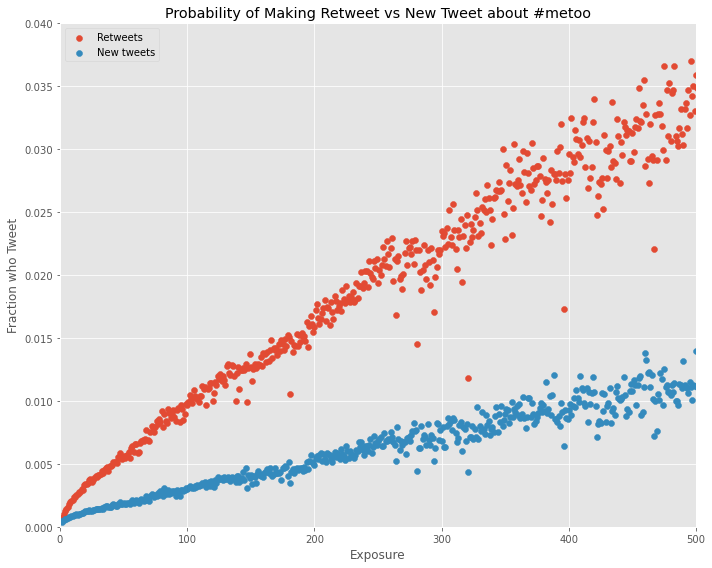

In [19]:
max_exposure = 500

fig, ax = plt.subplots(figsize=(10,8))
plt.scatter(x=ex_rt.views, y=ex_rt.prob_at_exact_exposure, label='Retweets')
plt.scatter(x=ex_new.views, y=ex_new.prob_at_exact_exposure, label='New tweets')
ax.set_ylabel('Fraction who Tweet')
ax.set_xlabel('Exposure')
ax.set_xlim(0, max_exposure)
ax.set_ylim(0, 0.04)
ax.set_title('Probability of Making Retweet vs New Tweet about #metoo')
plt.legend(loc='upper left')
plt.tight_layout()
plt.show()

#### Short answer 9:
- Does the data support your hypothesis? In a few sentences, say what your hypothesis was and why the data do or don't support it. 

**🤔Your answers here**

## Review
- In this lab, we showed some of the complexity that happens in the real world by looking more closely at social contagion in data from the #metoo hashtag on twitter. 
- We have explored different aspects of exposure and found several things:
    - Most people who tweet about #metoo do so with just a little exposure to it
    - The more exposure someone has, the more likely they are to tweet
    - Close friends are more influential than other friends
- We also looked at different kinds of participation when we compared retweeting with making new tweets, and found that some ways of joining a movement require less social influence than others.